In [74]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.8 MB/s eta 0:00:00


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preparing data

Using data from Hugging face

Working reference by
[Paper](https://arxiv.org/pdf/2110.15718v3.pdf)



In [83]:
from datasets import load_dataset

dataset = load_dataset("sms_spam")

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [88]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})

In [106]:
data_train_sms=dataset['train']
sms_texts=[]
label=[]
for text,labels in zip(data_train_sms['sms'],data_train_sms['label']):
  sms_texts.append(text)
  label.append(labels)

In [107]:
df_sms_spam=pd.DataFrame({
    "sms text":sms_texts,
    "labels":label
})

# EDA

In [108]:
df_sms_spam

,sms text,labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1
5570,Will ü b going to esplanade fr home?\n,0
5571,"Pity, * was in mood for that. So...any other s...",0
5572,The guy did some bitching but I acted like i'd...,0


Check how many labels

In [109]:
df_sms_spam['labels'].value_counts()

0    4827
1     747
Name: labels, dtype: int64

<Axes: ylabel='count'>

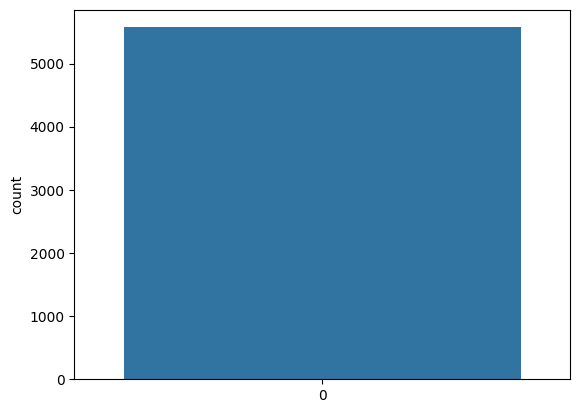

In [114]:
sns.countplot(data=df_sms_spam['labels'])

# Text preprocessing

text preprocessing techniques like stemming and stop words removal.